In [1]:
import gym,torch,torch.nn.functional as F,numpy as np,matplotlib.pyplot as plt,rl_utils
from tqdm import tqdm

In [2]:
class PolicyNet(torch.nn.Module):
    def __init__(self,state_dim,hidden_dim,action_dim):
        super(PolicyNet,self).__init__()
        # define input layer
        self.fc1=torch.nn.Linear(state_dim,hidden_dim)
        # define output layer
        self.fc2=torch.nn.Linear(hidden_dim,action_dim)

    def forward(self, x):
        # define forward pass
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x),dim=1)

In [3]:
class REINFORCE:
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma, device):
        self.policy_net = PolicyNet(state_dim, hidden_dim, action_dim).to(device)# 初始化策略网络
        self.optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=learning_rate)# 初始化优化器
        self.gamma = gamma
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.policy_net(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def update(self, transitions_dict):
        # 从字典中取出所有的训练数据
        reward_list = transitions_dict['rewards']
        action_list = transitions_dict['actions']
        state_list = transitions_dict['states']

        G = 0
        self.optimizer.zero_grad()
        for i in reversed(range(len(reward_list))):
            # 计算每一步的奖励
            reward = reward_list[i]
            state = torch.tensor([state_list[i]], dtype=torch.float).to(self.device)
            action = torch.tensor([action_list[i]]).view(1, -1).to(self.device)
            log_prob = torch.log(self.policy_net(state)).gather(1, action)
            G = reward + self.gamma * G
            # 策略网络的损失函数
            loss = -log_prob * G
            loss.backward()
        self.optimizer.step()

In [4]:
lr = 1e-3
num_episodes = 1000
hidden_dim = 128
gamma = 0.98
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'CartPole-v0'
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = REINFORCE(state_dim, hidden_dim, action_dim, lr, gamma, device)

return_list = []
for i in range(10):
    with tqdm(total=int(num_episodes / 10),                desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            transition_dict = {'states': [], 'actions': [], 'next_states': [], 'rewards': [], 'dones': []}
            state = env.reset()
            done = False
            while not done:
                action = agent.take_action(state)
                next_state, reward, done, _ = env.step([action])
                transition_dict['states'].append(state)
                transition_dict['actions'].append(action)
                transition_dict['next_states'].append(next_state)
                transition_dict['rewards'].append(reward)
                transition_dict['dones'].append(done)

                state = next_state
                episode_return += reward
            return_list.append(episode_return)
            agent.update(transition_dict)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

c:\vnstudio\lib\site-packages\gym\envs\registration.py:556: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  f"The environment {id} is out of date. You should consider "
Iteration 0:   0%|          | 0/100 [00:00<?, ?it/s]c:\vnstudio\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:204.)
  if __name__ == '__main__':
Iteration 0:   0%|          | 0/100 [00:00<?, ?it/s]


ValueError: expected sequence of length 4 at dim 2 (got 0)

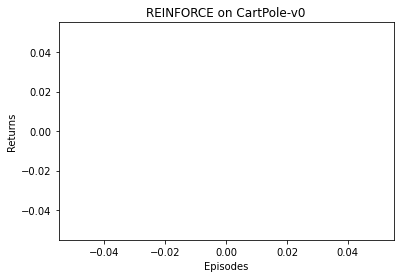

ValueError: operands could not be broadcast together with shapes (0,) (4,) 

In [5]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('REINFORCE on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('REINFORCE on {}'.format(env_name))
plt.show()